# **Modules**

In [4]:
from data_preparation.generate_sets import main as generate_sets
from data_preparation.datasets import main as generate_loaders_and_test_nan
from data_preparation.induce_nans import main as generate_test_masked
from data_preparation.preprocessing import preprocess_data

from models.MLP_AE import FullyConnectedAutoencoder
from models.Conv_AE import ConvAutoencoder
from models.LSTM_AE import LSTM_Autoencoder
from models.Transformer_Encoder import make_model

from training.train import train_model

from evaluations.nn_loss import ORT_MIT_Loss
from evaluations.utils import load_model, count_parameters
from evaluations.predict import predict
from evaluations.eval_classical_methods import evaluate_set
from evaluations.mse import evaluate_imputation_mse
from evaluations.t_test import t_test


from sklearn.preprocessing import MinMaxScaler

import torch
import pandas as pd
import configue
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(12, 3))

# configue
config = configue.load("./config.yaml")

torch.manual_seed(config["random_state"])

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-v4vy6cqe because the default path (/home/fervent_babbage/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


# **Data preprocessing**

In [6]:
generate_sets(config) 

Train, validation and test sets created


In [7]:
train, val, test = preprocess_data(config["path_train"], config["path_val"], config["path_test"], MinMaxScaler(), config["columns_to_drop"])
test_nan, test_mask = generate_test_masked(config,test)

masking done


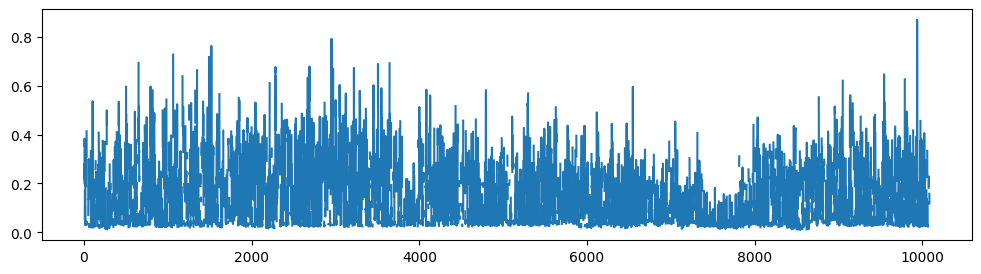

In [8]:
plt.plot(test_nan.Global_intensity)
plt.show()

# **DL models**

In [20]:
# Hyperparameters Intervals
LR_MIN=1e-6
LR_CEIL=1
MIN_EPOCHS=20
MAX_EPOCHS=70
MIN_SEQ_LEN=12
MAX_SEQ_LEN=96
BATCH_VALUES=[8,16,32,64]
LOSS_PARAMS_LIST=[0.5,2,2.5,4,6,8]
RP_MIN=0.4
RP_MAX=0.8
## Specific to Transformer model
MIN_DROPOUT=0.1
MAX_DROPOUT=0.8
d_ff_vals = [32,64]
N_vals = [2,3,4,5]
h_vals =[2,4]
d_model_vals = [16,64,128,512] # d_model%h ==0

### **Finetune the AutoEncoder**

In [12]:
NUM_TRIALS=2
config_ae_main = configue.load("./training/config_AE.yaml")

def objective_ae(trial: optuna.Trial):  
    config_ae = {
        "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
        "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
        "epochs": int(trial.suggest_discrete_uniform('epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)),
        "sequence_length": int(trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)),
        "batch_size": int(trial.suggest_categorical('batch_size', BATCH_VALUES)),
        "loss_parameter": trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST),
        "models_path": config_ae_main["models_path"]
    }
    
    input_dim = int(train.shape[1] * config_ae["sequence_length"])
    reduction_parameter = config_ae["reduction_parameter"]
    hidden_dim1 = int(input_dim * reduction_parameter)
    hidden_dim2 = int(hidden_dim1 * reduction_parameter)
    output_dim = input_dim
    print('sequence_length',config_ae["sequence_length"],'batch_size',config_ae["batch_size"],'epochs',config_ae["epochs"])
    print('input_dim',input_dim,'hidden_dim1',hidden_dim1,'hidden_dim2',hidden_dim2,'reduction_param',reduction_parameter)
    
    model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim1, hidden_dim2, output_dim)
    train_loader_ae, val_loader_ae, test_loader_ae = generate_loaders_and_test_nan(config, config_ae,train, val, test, test_nan, test_mask)
    if torch.cuda.is_available():
        model_ae = model_ae.cuda()
        
    loss_fn = ORT_MIT_Loss(config_ae["loss_parameter"])
    train_loss_list, val_loss_list, model_ae_PATH = train_model(model_ae,loss_fn,config_ae,input_dim,train_loader_ae,val_loader_ae, is_flatten=True, is_TS=False, is_warmed= True)
         
    return val_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective_ae, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2023-03-30 22:21:45,198] Trial 1 finished with value: 0.012822357547038154 and parameters: {'learning_rate': 2.702260642835954e-05, 'reduction_param': 0.5, 'epochs': 30.0, 'sequence_length': 12.0, 'batch_size': 32, 'loss_parameter': 0.5}. Best is trial 1 with value: 0.012822357547038154.


Number of finished trials: 2
Best trial:
  Value: 0.01282
  Params: 
    learning_rate: 2.702260642835954e-05
    reduction_param: 0.5
    epochs: 30.0
    sequence_length: 12.0
    batch_size: 32
    loss_parameter: 0.5


In [13]:
NUM_TRIALS = 30
config_conv_ae_main = configue.load("./training/config_convAE.yaml")

def objective_conv_ae(trial: optuna.Trial):  
    config_conv_ae = {
        "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
        "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
        "epochs": int(trial.suggest_discrete_uniform('epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)),
        "sequence_length": int(trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)),
        "batch_size": int(trial.suggest_categorical('batch_size', BATCH_VALUES)),
        "loss_parameter": trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST),
        "models_path": config_conv_ae_main["models_path"]
    }
    d_input = train.shape[1]
    input_dim = train.shape[1] * config_conv_ae["sequence_length"]
    
    reduction_parameter = config_conv_ae["reduction_parameter"]
    hidden_dim1 = int(input_dim * reduction_parameter)
    hidden_dim2 = int(hidden_dim1 * reduction_parameter)
    hidden_dim3 = int(hidden_dim2 * reduction_parameter)
    print('sequence_length',config_conv_ae["sequence_length"],'batch_size',config_conv_ae["batch_size"],'epochs',config_conv_ae["epochs"])
    print('input_dim',input_dim,'hidden_dim1',hidden_dim1,'hidden_dim2',hidden_dim2,'hidden_dim3',hidden_dim3,'reduction_param',reduction_parameter)

    #init model
    model_conv_ae = ConvAutoencoder(config_conv_ae["sequence_length"],d_input,hidden_dim1, hidden_dim2,hidden_dim3)
    if torch.cuda.is_available():
        model_conv_ae = model_conv_ae.cuda()    
    train_loader_conv_ae, val_loader_conv_ae, test_loader_conv_ae = generate_loaders_and_test_nan(config, config_conv_ae,train, val, test, test_nan, test_mask)
    loss_fn = ORT_MIT_Loss(config_conv_ae["loss_parameter"])
    train_loss_list, val_loss_list,model_conv_ae_path = train_model(model_conv_ae,loss_fn,config_conv_ae,input_dim,train_loader_conv_ae,val_loader_conv_ae, is_flatten=False, is_TS=False, is_warmed= False)
         
    return val_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective_conv_ae, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-03-30 22:22:12,301] A new study created in memory with name: deepl_finetune
/tmp/ipykernel_193/807545293.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
/tmp/ipykernel_193/807545293.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
/tmp/ipykernel_193/807545293.py:8: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

sequence_length 84 batch_size 32 epochs 40
input_dim 588 hidden_dim1 411 hidden_dim2 287 hidden_dim3 200 reduction_param 0.7000000000000001
total training batch number: 601
total validation batch number: 147
total test batch number: 10003
Epoch 0: train loss: 0.04633191165928039, val loss: 0.0342213681069057


[W 2023-03-30 22:22:26,943] Trial 0 failed with parameters: {'learning_rate': 0.0005819973643063753, 'reduction_param': 0.7000000000000001, 'epochs': 40.0, 'sequence_length': 84.0, 'batch_size': 32, 'loss_parameter': 0.5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/fervent_babbage/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_193/807545293.py", line 30, in objective_conv_ae
    train_loss_list, val_loss_list,model_conv_ae_path = train_model(model_conv_ae,loss_fn,config_conv_ae,input_dim,train_loader_conv_ae,val_loader_conv_ae, is_flatten=False, is_TS=False, is_warmed= False)
  File "/home/fervent_babbage/workdir/Unsupervised_Time_Series_Imputation/training/train.py", line 77, in train_model
    optimizer.step()
  File "/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py", line 68, in wrapper
    return wrapped(*args, 

KeyboardInterrupt: 

### **LSTM AE Finetuning**

In [15]:
NUM_TRIALS=30
config_lstm_ae_main = configue.load("./training/config_LSTM_AE.yaml")

def objective_lstm_ae(trial: optuna.Trial):     
    config_lstm_ae = {
        "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
        "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
        "epochs": int(trial.suggest_discrete_uniform('epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)),
        "sequence_length": int(trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)),
        "batch_size": int(trial.suggest_categorical('batch_size', BATCH_VALUES)),
        "loss_parameter": trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST),
        "models_path": config_lstm_ae_main["models_path"]
    }
    d_input = train.shape[1]
    embedding_size = int(d_input * config_lstm_ae["reduction_parameter"])

    print('sequence_length',config_lstm_ae["sequence_length"],'batch_size',config_lstm_ae["batch_size"],'epochs',config_lstm_ae["epochs"])
    print('d_input',d_input,'embedding_size',embedding_size,'reduction_param',config_lstm_ae["reduction_parameter"])
    
    model_ae_lstm = LSTM_Autoencoder(config_lstm_ae["sequence_length"],d_input,embedding_size)

    if torch.cuda.is_available():
        model_ae_lstm = model_ae_lstm.cuda()    
        
    train_loader_lstm_ae, val_loader_lstm_ae, test_loader_lstm_ae = generate_loaders_and_test_nan(config, config_lstm_ae,train, val, test, test_nan, test_mask)

    loss_fn = ORT_MIT_Loss(config_lstm_ae["loss_parameter"])
    
    train_loss_list, val_loss_list,model_ae_lstm_path = train_model(model_ae_lstm,loss_fn,config_lstm_ae,d_input,train_loader_lstm_ae,val_loader_lstm_ae, is_flatten=False, is_TS=False, is_warmed= True)
         
    return val_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective_lstm_ae, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-03-30 22:23:03,221] A new study created in memory with name: deepl_finetune
/tmp/ipykernel_193/368072172.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
/tmp/ipykernel_193/368072172.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
/tmp/ipykernel_193/368072172.py:8: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :

sequence_length 60 batch_size 8 epochs 30
d_input 7 embedding_size 5 reduction_param 0.8
total training batch number: 2406
total validation batch number: 590
total test batch number: 10027
Epoch 0: train loss: 0.0447399020504674, val loss: 0.03531352722133368


[W 2023-03-30 22:23:29,109] Trial 0 failed with parameters: {'learning_rate': 2.2404813938008414e-05, 'reduction_param': 0.8, 'epochs': 30.0, 'sequence_length': 60.0, 'batch_size': 8, 'loss_parameter': 0.5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/fervent_babbage/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_193/368072172.py", line 29, in objective_lstm_ae
    train_loss_list, val_loss_list,model_ae_lstm_path = train_model(model_ae_lstm,loss_fn,config_lstm_ae,d_input,train_loader_lstm_ae,val_loader_lstm_ae, is_flatten=False, is_TS=False, is_warmed= True)
  File "/home/fervent_babbage/workdir/Unsupervised_Time_Series_Imputation/training/train.py", line 77, in train_model
    optimizer.step()
  File "/home/fervent_babbage/workdir/Unsupervised_Time_Series_Imputation/training/utils.py", line 19, in step
    self.optimizer.step()
  Fi

KeyboardInterrupt: 

## **Transformer Encoder Finetuning**

In [21]:
NUM_TRIALS=20
config_ts_main = configue.load("./training/config_TS.yaml")


def objective_ts(trial: optuna.Trial): 

    config_ts = {
        "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
        "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
        "epochs": int(trial.suggest_discrete_uniform('epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)),
        "sequence_length": int(trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)),
        "batch_size": int(trial.suggest_categorical('batch_size', BATCH_VALUES)),
        "loss_parameter": trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST),
        "h": trial.suggest_categorical('h', h_vals),
        "N": trial.suggest_categorical('N', N_vals),
        "d_ff": trial.suggest_categorical('d_ff', d_ff_vals),
        "d_model": trial.suggest_categorical('d_model', d_model_vals),
        "dropout": trial.suggest_discrete_uniform('dropout', MIN_DROPOUT, MAX_DROPOUT,q=0.1),
        "models_path": config_ts_main["models_path"]
    }

    d_input = train.shape[1]
    print('sequence_length',config_ts["sequence_length"],'batch_size',config_ts["batch_size"],'epochs',config_ts["epochs"])
    TS_model = make_model(d_input=d_input, N=config_ts["N"], d_model=config_ts["d_model"], d_ff=config_ts["d_ff"], h=config_ts["h"], dropout=config_ts["dropout"])
    if torch.cuda.is_available():
        TS_model = TS_model.cuda()  
        
    train_loader_ts, val_loader_ts, test_loader_ts = generate_loaders_and_test_nan(config, config_ts,train, val, test, test_nan, test_mask)

    loss_fn = ORT_MIT_Loss(config_ts["loss_parameter"])
    
    train_loss_list, val_loss_list,TS_model_Path = train_model(TS_model,loss_fn,config_ts,d_input,train_loader_ts,val_loader_ts, is_flatten=False, is_TS=True, is_warmed= False)
         
    return val_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective_ts, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-03-30 22:28:03,086] A new study created in memory with name: deepl_finetune
/tmp/ipykernel_193/3413577460.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL),
/tmp/ipykernel_193/3413577460.py:9: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reduction_parameter": trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1),
/tmp/ipykernel_193/3413577460.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

sequence_length 72 batch_size 8 epochs 50
total training batch number: 2405
total validation batch number: 588
total test batch number: 10015
Epoch 0: train loss: 1.2759495748055947, val loss: 0.6231980677567371


[W 2023-03-30 22:29:58,917] Trial 0 failed with parameters: {'learning_rate': 1.6719980621269522e-06, 'reduction_param': 0.8, 'epochs': 50.0, 'sequence_length': 72.0, 'batch_size': 8, 'loss_parameter': 8, 'h': 4, 'N': 5, 'd_ff': 64, 'd_model': 128, 'dropout': 0.6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/fervent_babbage/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_193/3413577460.py", line 32, in objective_ts
    train_loss_list, val_loss_list,TS_model_Path = train_model(TS_model,loss_fn,config_ts,d_input,train_loader_ts,val_loader_ts, is_flatten=False, is_TS=True, is_warmed= False)
  File "/home/fervent_babbage/workdir/Unsupervised_Time_Series_Imputation/training/train.py", line 76, in train_model
    loss.backward()
  File "/usr/local/lib/python3.8/dist-packages/torch/_tensor.py", line 488, in backward
    torch.autograd.backwa

KeyboardInterrupt: 